# Artificial Neural Networks and Deep Learning


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [164]:
%pip install tensorflow==2.17.0
%pip install keras==3.4.1
%pip install keras_cv


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [165]:
# Try to import the Google Colab module
try:
    import google.colab
    is_colab = True
except:
    is_colab = False
print('is_colab:', is_colab)

is_colab: False


In [166]:
# If we are in Google Colab, mount the Google Drive
# The exact location depends on where you have stored your files
if is_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd "/gdrive/My Drive/Colab Notebooks/[2024-2025] AN2DL/Homework 1"

In [167]:
seed = 42

import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_cv as kcv

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(seed)
tf.random.set_seed(seed)

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


In [168]:
print(f"Tensorflow resources: {tf.config.list_physical_devices()}")

Tensorflow resources: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [169]:
if is_colab:
    dataset_path = 'Challenge 1/Preprocessing/balanced_dataset.npz'
else:
    dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(dataset_path)
X = data['images']
y = data['labels']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Show the shape of the dataset
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (18640, 96, 96, 3)
y shape: (18640,)


## Process the Data


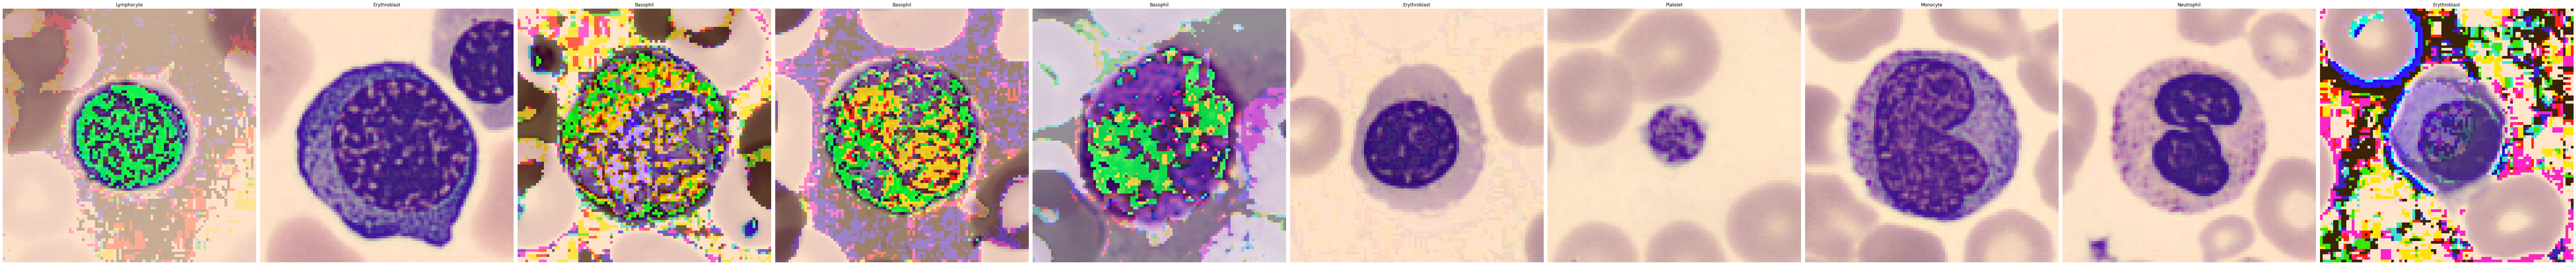

In [170]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(96, 96))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(labels[y[idx]])
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [171]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
7    2330
3    2330
6    2330
2    2330
1    2330
5    2330
0    2330
4    2330
Name: count, dtype: int64


In [172]:
# Normalize the data to the range [0, 1] and encode output labels
X = (X / 255).astype('float32')
y = tfk.utils.to_categorical(y, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

Training data shape: (13048, 96, 96, 3), Validation data shape: (5592, 96, 96, 3)
Training labels shape: (13048, 8), Validation labels shape: (5592, 8)


## Data Augmentation on Training Set
On the training set, we could take advantage of the CutMix and MixUp techniques explained here: ...

In [173]:
def mixup (x1, y1, x2, y2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    new_x = lam * x1 + (1 - lam) * x2
    new_y = lam * y1 + (1 - lam) * y2
    return new_x, new_y

In [174]:
# Select 30% of the data for MixUp
subset_size = int(0.5 * len(X_train))
indices = np.random.choice(len(X_train), subset_size, replace=False)

# Create subset of the data
X_subset = X_train[indices]
y_subset = y_train[indices]

print(f'Subset data shape: {X_subset.shape}, Subset labels shape: {y_subset.shape}')

Subset data shape: (6524, 96, 96, 3), Subset labels shape: (6524, 8)


In [175]:
# Apply MixUp
X_augmented = []
y_augmented = []

for i in range(subset_size):
    j = np.random.randint(0, len(X_train))
    mixed_x, mixed_y = mixup(X_subset[i], y_subset[i], X_train[j], y_train[j])
    X_augmented.append(mixed_x)
    y_augmented.append(mixed_y)

# Convert to numpy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Concatenate back with original dataset
X_train_augmented = np.concatenate([X_train, X_augmented], axis=0)
y_train_augmented = np.concatenate([y_train, y_augmented], axis=0)

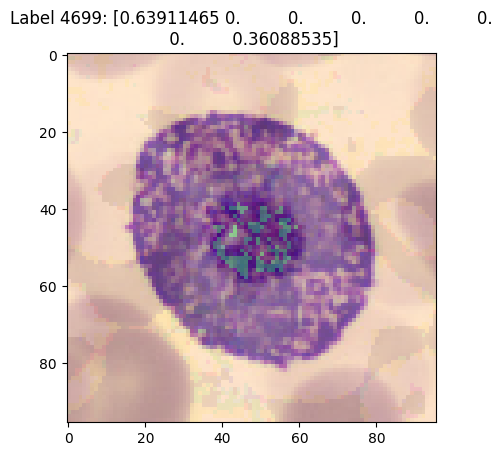

In [176]:
i = random.randint(0, len(X_augmented))
plt.title(f'Label {i}: {y_augmented[i]}')
plt.imshow(X_augmented[i])

## Data Augmentation on Validation Set
The purpose of applying random data augmentations on the validation set is to have a more or less compatible idea on what is assessed by the test set. 

Since we don't know how test data is, we use some random augmentations.

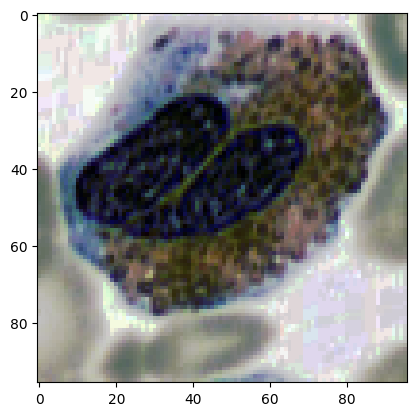

In [177]:
X_val_augmented = kcv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.3)(X_val)

# Display a sample of images from the validation dataset
i = 100
plt.imshow(X_val_augmented[i])

# Assign the augmented validation data to the original validation data
X_val = X_val_augmented

## 🛠️ Train and Save the Model

In [178]:
# Hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.001

# Retrieve input and output shape
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

In [179]:
def build_model (
    input_shape = input_shape,
    output_shape = output_shape,
    learning_rate = learning_rate,
    dropout_rate = 0.5,
    augmentation = None,
    flatten = True,
    seed = seed):

  tf.random.set_seed(seed)

  # Input layer
  inputs = tfkl.Input(shape=input_shape, name='Input')

  # Apply augmentation layers, if specified, and create the first convolutional layer
  if augmentation is None:
    x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='Conv2D_1')(inputs)
  else:
    x = augmentation(inputs)
    x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='Conv2D_1')(x)
  x = tfkl.MaxPooling2D(pool_size=2, name='MaxPooling2D_1')(x)

  x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='Conv2D_2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D(name='mp2')(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv2D_3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D(name='mp3')(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='Conv2D_4')(x)
  x = tfkl.ReLU(name='relu4')(x)
  x = tfkl.MaxPooling2D(name='mp4')(x)

  # Flatten layer
  if flatten == True:
    x = tfkl.Flatten(name='Flatten')(x)
  else:
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

  # Fully connected layers
  x = tfkl.Dense(units=128, name='Dense_1')(x)
  x = tfkl.BatchNormalization(name='BatchNormalization_1')(x)
  x = tfkl.Activation('relu', name='Activation_1')(x)
  x = tfkl.Dropout(rate=dropout_rate, name='Dropout_1')(x)

  x = tfkl.Dense(units=128, name='Dense_2')(x)
  x = tfkl.BatchNormalization(name='BatchNormalization_2')(x)
  x = tfkl.Activation('relu', name='Activation_2')(x)
  x = tfkl.Dropout(rate=dropout_rate, name='Dropout_2')(x)

  # Output layer
  x = tfkl.Dense(units=output_shape, name='Output')(x)
  outputs = tfkl.Activation('softmax', name='Activation_Output')(x)

  # Create the model
  model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN_Model')

  # Compile the model
  loss = tfk.losses.CategoricalCrossentropy()
  optimizer = tfk.optimizers.Adam(learning_rate)
  metrics = ['accuracy']
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  return model

In [180]:
# Define a data augmentation pipeline
# Layer performing some geometric operations, that resemble that of the RandAugment
# layer (which was too computationally demanding to be used inside the network).
augmentation = tf.keras.Sequential ([
      tfkl.RandomBrightness(0.2, value_range=(0, 1)),
      tfkl.RandomFlip(mode="horizontal_and_vertical"),
      tfkl.RandomTranslation(0.2, 0.2),
      tfkl.RandomZoom(0.2),
      tfkl.RandomRotation(0.2),
      tfkl.RandomContrast(0.2)
], name='augment')

In [181]:
# Early stopping callbacks
patience = 10

# Create an early stopping on validation accuracy
early_stopping_accuracy = tfk.callbacks.EarlyStopping (
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)
callbacks = [early_stopping_accuracy]

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ augment (Sequential)        │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_1    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip            │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_2   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_zoom            │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomZoom)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation        │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_1      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_1 (Conv2D)           │ (None, 96, 96, 16)    │        448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ MaxPooling2D_1              │ (None, 48, 48, 16)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_2 (Conv2D)           │ (None, 48, 48, 32)    │      4,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu2 (ReLU)                │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_3 (Conv2D)           │ (None, 24, 24, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu3 (ReLU)                │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp3 (MaxPooling2D)          │ (None, 12, 12, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_4 (Conv2D)           │ (None, 12, 12, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu4 (ReLU)                │ (None, 12, 12, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp4 (MaxPooling2D)          │ (None, 6, 6, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ GlobalAveragePooling2D      │ (None, 128)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_1 (Dense)             │ (None, 128)           │     16,512 │   Y 

 Total params: 132,520 (517.66 KB)

 Trainable params: 132,008 (515.66 KB)

 Non-trainable params: 512 (2.00 KB)

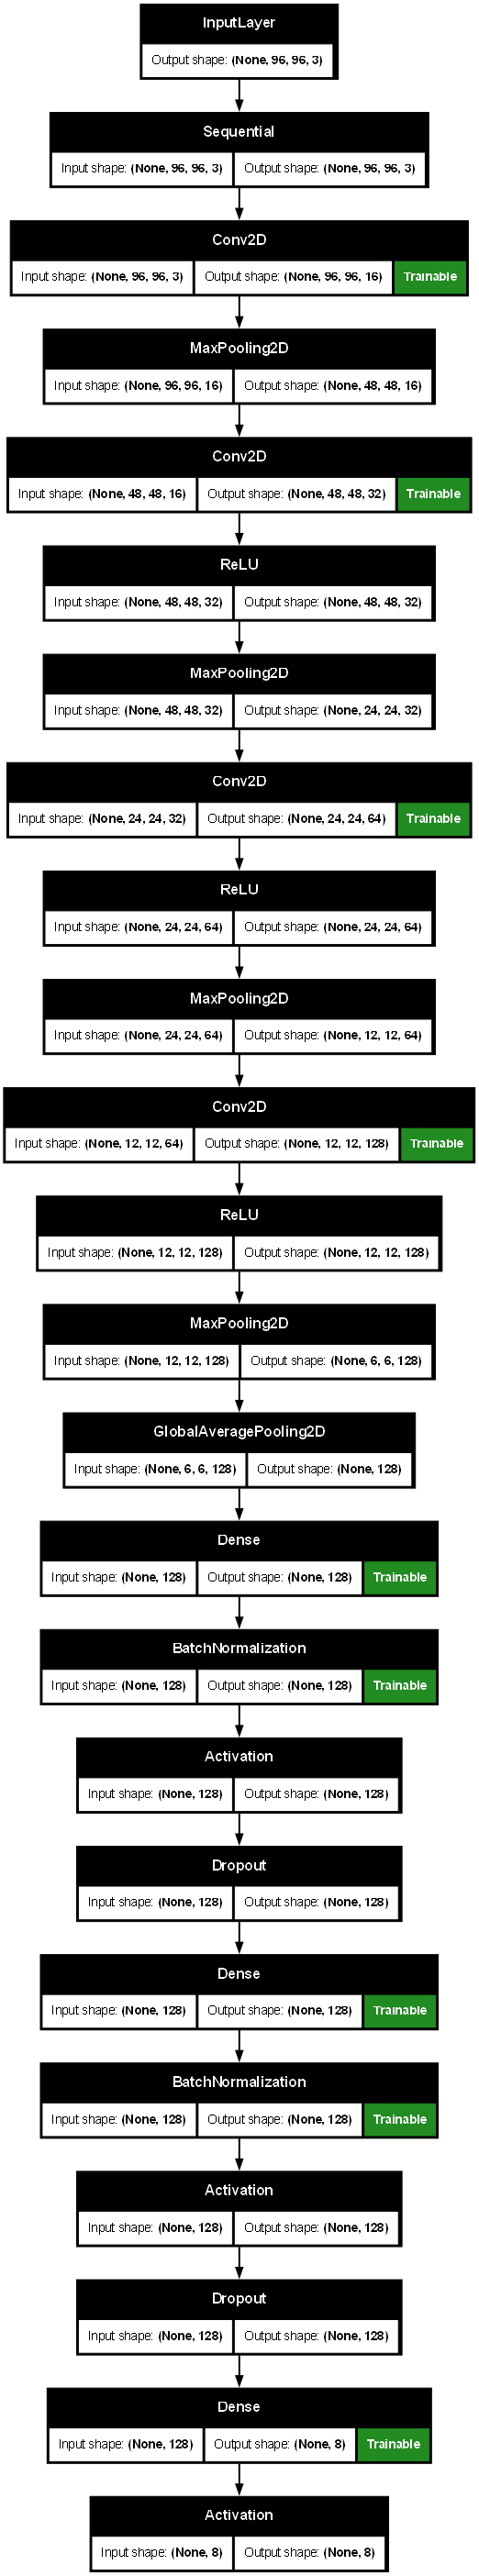

In [182]:
# Build the model with specified input and output shapes
model = build_model(flatten=False, augmentation=augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [183]:
history = model.fit (
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.3001 - loss: 1.9808 - val_accuracy: 0.2042 - val_loss: 2.1709
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.5413 - loss: 1.1824 - val_accuracy: 0.3280 - val_loss: 2.5034
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.6259 - loss: 0.9667 - val_accuracy: 0.2766 - val_loss: 2.4915
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6746 - loss: 0.8548 - val_accuracy: 0.3165 - val_loss: 2.5551
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.7124 - loss: 0.7854 - val_accuracy: 0.3380 - val_loss: 2.7276
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.7563 - loss: 0.6936 - val_accuracy: 0.3704 - val_loss: 2.8780
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.7841 - loss: 0.6450 - val_accuracy: 0.3841 - val_loss: 2.7818
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.7849 - loss: 0

175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
(5592,)


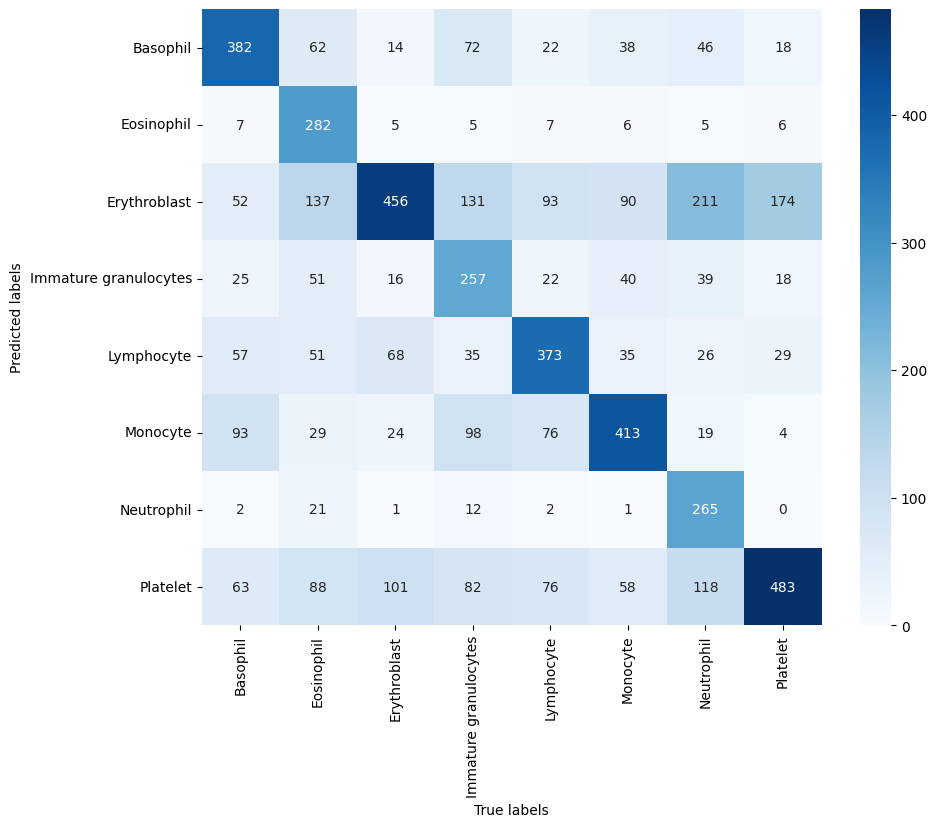

In [184]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)

print(pred_classes.shape)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

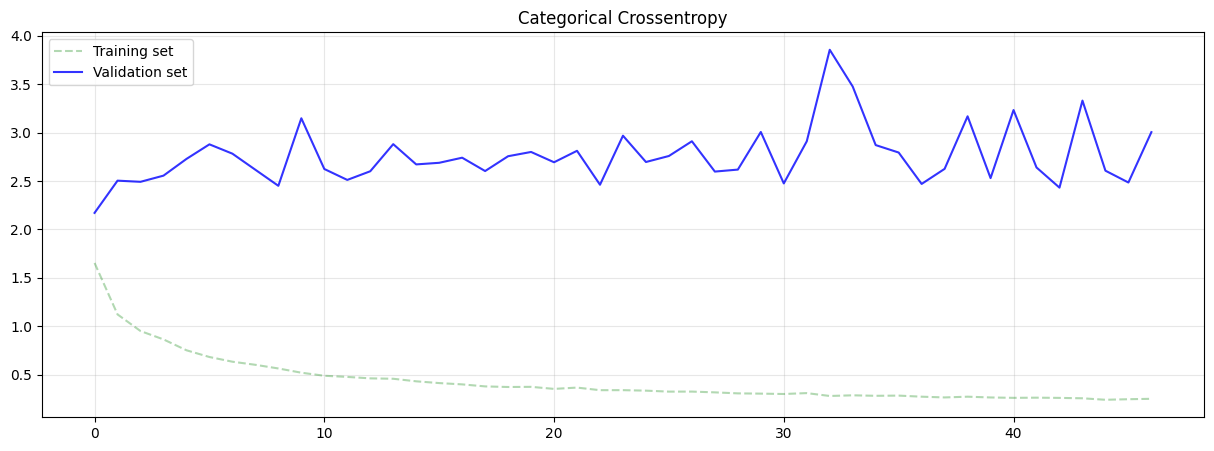

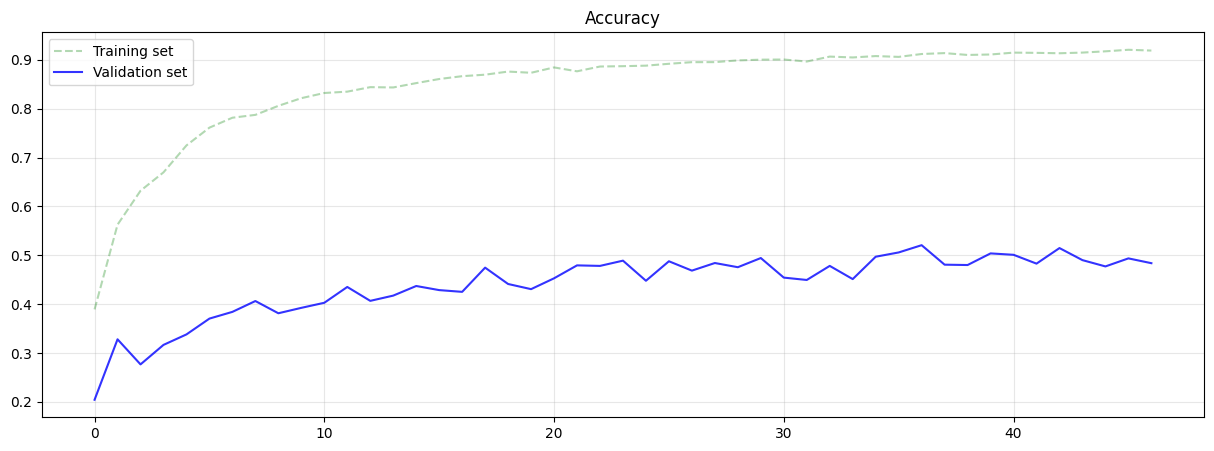

In [185]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

In [186]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds
        

Overwriting model.py


In [187]:
# If we are in Google Colab, directly create the .zip file
# containing the model and the weights.
# Otherwise, the file should be created manually
if is_colab:
    from datetime import datetime
    filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

    # Add files to the zip command
    !zip {filename} model.py weights.keras

    from google.colab import files
    files.download(filename)